# Goal Kick Probability Model

In [1]:
import numpy as np
import pandas as pd
import pickle
from patsy import dmatrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.lines import Line2D

In [2]:
BUNDLE_PATH = r"C:\Users\olwyn\OneDrive\Desktop\Working Models\Goal Kicking Model\Exports\goal_kick_bundle.pkl"
with open(BUNDLE_PATH, "rb") as f:
    GK = pickle.load(f)
DIST_BASIS_COLS = [c[len("dist_"):] for c in GK["X_cols"] if c.startswith("dist_")]
ANG_BASIS_COLS  = [c[len("ang_"):]  for c in GK["X_cols"] if c.startswith("ang_")]
def _z(x: float, mu: float, sd: float) -> float:
    x = float(x); mu = float(mu); sd = float(sd)
    return (x - mu) / sd if sd > 0 else 0.0
def _bs_row_named(var_name: str, var_val: float, spec: dict, target_cols: list[str]) -> pd.DataFrame:
    """
    Build 1-row bs() basis using saved knots/bounds, then FORCE column names
    to match the training column names (critical).
    """
    tmp = pd.DataFrame({var_name: [float(var_val)]})
    knots = list(np.asarray(spec["knots"], dtype=float))
    lb = float(spec["lower_bound"])
    ub = float(spec["upper_bound"])
    deg = int(spec["degree"])
    inc = bool(spec.get("include_intercept", False))

    formula = (
        f"bs({var_name}, knots={knots}, degree={deg}, include_intercept={inc}, "
        f"lower_bound={lb}, upper_bound={ub}) - 1"
    )
    B = dmatrix(formula, tmp, return_type="dataframe")

    if B.shape[1] != len(target_cols):
        raise ValueError(f"{var_name} basis dim mismatch: got {B.shape[1]} cols, expected {len(target_cols)}")

    B.columns = target_cols
    return B
def kick_success_prob_from_inputs(
    *,
    location: tuple[float, float],   # (lat_d, lon_d) = (metres from left touchline, metres from try line)
    pitch: str,
    wind_direction_deg: float,       # meteorological "from" (0=N, 90=E, 180=S, 270=W)
    wind_magnitude: float,           # same units as training
    wind_gusts: float,               # same units as training
    playing_direction: str,          # 16-point compass e.g. "N", "E", "SSE"
    playerName: str | None = None,
    unseen_kicker: str = "mean",     # "mean" -> u_k=0; "error" -> raise
    pitch_length: float = 100.0,
    posts_y: float = 35.0,
    post_half_width: float = 2.8,
) -> float:
    """
    Single replacement for:
      - make_wind_feature_function(...)
      - kick_success_prob(...)

    Requires your existing globals/helpers already defined in the notebook:
      GK, _z, _bs_row_named, DIST_BASIS_COLS, ANG_BASIS_COLS
    """

    # ---------------------------------------------------
    # (A) Geometry: distance + angle from location
    # ---------------------------------------------------
    POST_Y = posts_y
    POST_HALF_WIDTH = post_half_width

    lat_d, lon_d = float(location[0]), float(location[1])

    lateral_offset = abs(lat_d - POST_Y)
    distance = float(np.sqrt(lon_d**2 + lateral_offset**2))

    # This matches your snippet exactly
    angle_rad = 2.0 * np.arctan(POST_HALF_WIDTH / distance) if distance > 0 else np.pi
    angle = float(np.degrees(angle_rad))

    # ---------------------------------------------------
    # (B) Wind: compute wind components relative to THIS kick
    # ---------------------------------------------------
    PITCH_BEARING_DEG = {
        "Energia Park": 139.77419385200756,
        "Woodleigh Park": 173.97478606125208,
        "New Ormond Park": 127.39468267351754,
        "Dub Pavilion": 143.1827386765416,
        "Ollie Campbell Park": 135.8704762203763,
        "Blackrock College RFC": 67.46625969624938,
        "College Park": 95.29082684403147,
        "Forenaughts": 192.09237196498472,
        "Thomond Park (Back Pitch)": 186.3577076046824,
        "The Mardyke": 127.09673208441768,
        "Thomond Park": 186.29435107216887,
        "Dooradoyle": 158.73290173265707,
        "Shaws Bridge": 78.6826621523989,
        "Palace Grounds": 133.35505196300585,
    }

    _COMPASS_16 = [
        "N","NNE","NE","ENE","E","ESE","SE","SSE",
        "S","SSW","SW","WSW","W","WNW","NW","NNW"
    ]
    _COMPASS_TO_DEG = {d: 22.5*i for i, d in enumerate(_COMPASS_16)}

    if pitch not in PITCH_BEARING_DEG:
        raise KeyError(f"Pitch '{pitch}' not recognised.")
    pd_dir = playing_direction.strip().upper()
    if pd_dir not in _COMPASS_TO_DEG:
        raise ValueError(f"Invalid playing_direction '{playing_direction}'.")

    pitch_bearing = float(PITCH_BEARING_DEG[pitch])
    attack_bearing = float(_COMPASS_TO_DEG[pd_dir])

    # Decide which posts are being attacked (x=100 or x=0)
    diff = abs((attack_bearing - pitch_bearing + 180.0) % 360.0 - 180.0)
    attacking_plus_x = diff <= 90.0

    x_target = float(pitch_length) if attacking_plus_x else 0.0
    y_target = float(posts_y)

    # Ball flight vector in pitch coords: (Metres2, y_coord) -> posts centre
    # Here we interpret your location as:
    #   Metres2 = lon_d (metres from try line, i.e. along-length coordinate)
    #   y_coord = lat_d (metres from left touch line, i.e. lateral coordinate)
    Metres2 = lon_d
    y_coord = lat_d

    dx = x_target - Metres2
    dy = y_target - y_coord

    # Convert pitch vector -> Earth EN
    b = np.deg2rad(pitch_bearing)
    sinb, cosb = float(np.sin(b)), float(np.cos(b))

    ball_e = dx*sinb + dy*cosb
    ball_n = dx*cosb - dy*sinb
    norm = float(np.hypot(ball_e, ball_n))
    if norm == 0.0:
        u_be, u_bn = 0.0, 0.0
    else:
        u_be, u_bn = ball_e / norm, ball_n / norm

    # Wind vector in Earth EN (meteorological "from" -> "to")
    dir_to = (float(wind_direction_deg) + 180.0) % 360.0
    th = np.deg2rad(dir_to)
    w_e = float(wind_magnitude) * float(np.sin(th))
    w_n = float(wind_magnitude) * float(np.cos(th))

    along = w_e*u_be + w_n*u_bn  # + tailwind, - headwind
    cross_e = w_e - along*u_be
    cross_n = w_n - along*u_bn
    wind_cross_abs = float(np.hypot(cross_e, cross_n))
    wind_along_pos = float(max(0.0, along))
    wind_along_head_abs = float(max(0.0, -along))
    avg_wind_gusts = float(wind_gusts)

    # ---------------------------------------------------
    # (C) Your existing kick_success_prob model code
    # ---------------------------------------------------
    cross_z = _z(wind_cross_abs, GK["wind_cross_abs_mu"], GK["wind_cross_abs_sd"])
    tail_z  = _z(wind_along_pos, GK["wind_along_pos_mu"], GK["wind_along_pos_sd"])
    head_z  = _z(wind_along_head_abs, GK["wind_along_head_abs_mu"], GK["wind_along_head_abs_sd"])
    gust_z  = _z(avg_wind_gusts, GK["gusts_mu"], GK["gusts_sd"])

    Bd = _bs_row_named("distance", distance, GK["dist_bs"], DIST_BASIS_COLS)
    Ba = _bs_row_named("angle", angle, GK["ang_bs"], ANG_BASIS_COLS)

    Xc = Bd.mul(cross_z, axis=0).add_prefix("cross_x_")
    Xt = Bd.mul(tail_z,  axis=0).add_prefix("tail_x_")
    Xh = Bd.mul(head_z,  axis=0).add_prefix("head_x_")

    X_row = pd.concat(
        [
            Bd.add_prefix("dist_"),
            Ba.add_prefix("ang_"),
            Xc, Xt, Xh,
            pd.DataFrame({"avg_wind_gusts_z": [gust_z]}),
        ],
        axis=1
    )

    X_row = X_row.reindex(columns=GK["X_cols"], fill_value=0.0)

    u_k = 0.0
    if playerName is not None:
        if playerName in GK["kicker_to_idx"]:
            u_k = float(GK["u_hat"][GK["kicker_to_idx"][playerName]])
        else:
            if unseen_kicker == "error":
                raise KeyError(f"Unseen kicker: {playerName}")

    eta = float(GK["beta0_hat"] + (X_row.values @ GK["beta_hat"]).item() + u_k)
    return float(1.0 / (1.0 + np.exp(-eta)))

In [36]:
# Location of kick (metres from the left touch line, metres from try line):
location = (10, 30)

# Wind conditions:
pitch_name = "College Park"
wind_direction_deg = 110
wind_magnitude = 10.4
wind_gusts = 16.9
playing_direction = "W"

# Kicker:
playerName = "Matty Lynch"



In [38]:
p_make = kick_success_prob_from_inputs(
    location=location,
    pitch=pitch_name,
    wind_direction_deg=wind_direction_deg,
    wind_magnitude=wind_magnitude,
    wind_gusts=wind_gusts,
    playing_direction=playing_direction,
    playerName=playerName,
)

print("Kick success probability:", p_make)

Kick success probability: 0.8294539217918977


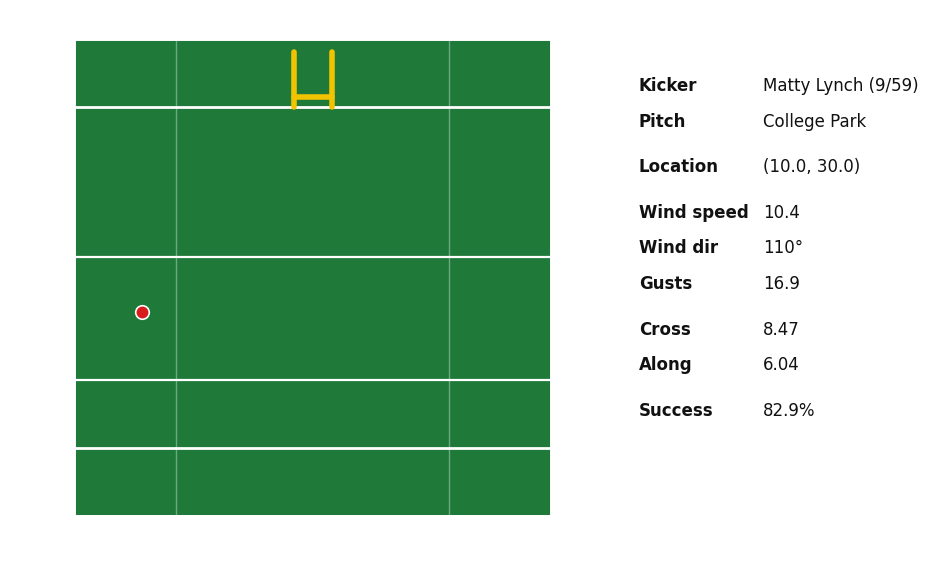

0.8294539217918977

In [39]:
def plot_goal_kick_panel(
    *,
    location_xy: tuple[float, float],
    pitch: str,
    wind_direction_deg: float,
    wind_magnitude: float,
    wind_gusts: float,
    playing_direction: str,
    playerName: str | None,
    GK: dict,
    DIST_BASIS_COLS: list[str],
    ANG_BASIS_COLS: list[str],
    title: str = "Goal Kick Scenario",
    figsize=(11.5, 6.2),
    y_view_max: float = 60.0,   # <-- crop at bottom (default 60m line)
    show: bool = True,
    savepath: str | None = None,
):
    """
    Self-contained plot:
      - Computes geometry, relative wind (cross/along), model success probability
      - Crops pitch to y ∈ [-10, y_view_max] to save space
      - Cleaner info panel (bold labels, no hard border box)
    Coordinate system expected (matches your notebook):
      - location_xy = (x from left touchline 0..70, y from try line 0..100; in-goal -10..110)
    """

    # -----------------------------
    # Helpers
    # -----------------------------
    def _z(x, mu, sd):
        return (float(x) - float(mu)) / float(sd) if float(sd) > 0 else 0.0

    def _kicker_rank_text(name: str | None) -> str:
        if not name or name not in GK.get("kicker_to_idx", {}):
            return "—"
        effects = {n: float(GK["u_hat"][idx]) for n, idx in GK["kicker_to_idx"].items()}
        ordered = sorted(effects.items(), key=lambda kv: kv[1], reverse=True)
        names = [n for n, _ in ordered]
        r = names.index(name) + 1
        return f"{r}/{len(names)}"

    # -----------------------------
    # Pitch / wind metadata (keep inside function for cleanliness)
    # -----------------------------
    PITCH_BEARING_DEG = {
        "Energia Park": 139.77419385200756,
        "Woodleigh Park": 173.97478606125208,
        "New Ormond Park": 127.39468267351754,
        "Dub Pavilion": 143.1827386765416,
        "Ollie Campbell Park": 135.8704762203763,
        "Blackrock College RFC": 67.46625969624938,
        "College Park": 95.29082684403147,
        "Forenaughts": 192.09237196498472,
        "Thomond Park (Back Pitch)": 186.3577076046824,
        "The Mardyke": 127.09673208441768,
        "Thomond Park": 186.29435107216887,
        "Dooradoyle": 158.73290173265707,
        "Shaws Bridge": 78.6826621523989,
        "Palace Grounds": 133.35505196300585,
    }
    _COMPASS_16 = ["N","NNE","NE","ENE","E","ESE","SE","SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    _COMPASS_TO_DEG = {d: 22.5*i for i, d in enumerate(_COMPASS_16)}

    if pitch not in PITCH_BEARING_DEG:
        raise KeyError(f"Pitch '{pitch}' not recognised in PITCH_BEARING_DEG.")
    pd_dir = playing_direction.strip().upper()
    if pd_dir not in _COMPASS_TO_DEG:
        raise ValueError(f"Invalid playing_direction '{playing_direction}'.")

    pitch_bearing = float(PITCH_BEARING_DEG[pitch])
    attack_bearing = float(_COMPASS_TO_DEG[pd_dir])

    # -----------------------------
    # Geometry
    # -----------------------------
    xk, yk = float(location_xy[0]), float(location_xy[1])

    POSTS_LATERAL_X = 35.0
    POST_HALF_WIDTH = 2.8

    lateral_offset = abs(xk - POSTS_LATERAL_X)
    distance = float(np.sqrt(yk**2 + lateral_offset**2))
    angle_rad = 2.0 * np.arctan(POST_HALF_WIDTH / distance) if distance > 0 else np.pi
    angle = float(np.degrees(angle_rad))

    # -----------------------------
    # Wind relative to THIS kick
    # (same logic as your kick_success_prob_from_inputs)
    # -----------------------------
    diff = abs((attack_bearing - pitch_bearing + 180.0) % 360.0 - 180.0)
    attacking_plus_x = diff <= 90.0

    pitch_length = 100.0
    x_target = pitch_length if attacking_plus_x else 0.0
    y_target = POSTS_LATERAL_X

    # "along-length" is yk in your location convention
    dx = x_target - yk
    dy = y_target - xk

    b = np.deg2rad(pitch_bearing)
    sinb, cosb = float(np.sin(b)), float(np.cos(b))

    ball_e = dx*sinb + dy*cosb
    ball_n = dx*cosb - dy*sinb
    norm = float(np.hypot(ball_e, ball_n))
    if norm == 0.0:
        u_be, u_bn = 0.0, 0.0
    else:
        u_be, u_bn = ball_e / norm, ball_n / norm

    # meteorological "from" -> "to"
    dir_to = (float(wind_direction_deg) + 180.0) % 360.0
    th = np.deg2rad(dir_to)
    w_e = float(wind_magnitude) * float(np.sin(th))
    w_n = float(wind_magnitude) * float(np.cos(th))

    along = w_e*u_be + w_n*u_bn
    cross_e = w_e - along*u_be
    cross_n = w_n - along*u_bn

    wind_cross_abs = float(np.hypot(cross_e, cross_n))
    rel_wind_along = float(along)  # + tailwind, - headwind

    # -----------------------------
    # Model probability
    # -----------------------------
    cross_z = _z(wind_cross_abs, GK["wind_cross_abs_mu"], GK["wind_cross_abs_sd"])
    tail_z  = _z(max(0.0, rel_wind_along), GK["wind_along_pos_mu"], GK["wind_along_pos_sd"])
    head_z  = _z(max(0.0, -rel_wind_along), GK["wind_along_head_abs_mu"], GK["wind_along_head_abs_sd"])
    gust_z  = _z(float(wind_gusts), GK["gusts_mu"], GK["gusts_sd"])

    Bd = _bs_row_named("distance", distance, GK["dist_bs"], DIST_BASIS_COLS)
    Ba = _bs_row_named("angle", angle, GK["ang_bs"], ANG_BASIS_COLS)

    Xc = Bd.mul(cross_z, axis=0).add_prefix("cross_x_")
    Xt = Bd.mul(tail_z,  axis=0).add_prefix("tail_x_")
    Xh = Bd.mul(head_z,  axis=0).add_prefix("head_x_")

    X_row = pd.concat(
        [
            Bd.add_prefix("dist_"),
            Ba.add_prefix("ang_"),
            Xc, Xt, Xh,
            pd.DataFrame({"avg_wind_gusts_z": [gust_z]}),
        ],
        axis=1
    ).reindex(columns=GK["X_cols"], fill_value=0.0)

    u_k = 0.0
    if playerName and playerName in GK["kicker_to_idx"]:
        u_k = float(GK["u_hat"][GK["kicker_to_idx"][playerName]])

    eta = float(GK["beta0_hat"] + (X_row.values @ GK["beta_hat"]).item() + u_k)
    p_success = float(1.0 / (1.0 + np.exp(-eta)))

    # -----------------------------
    # Plot layout (pitch + info)
    # -----------------------------
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[3.0, 1.55], wspace=0.05)
    ax = fig.add_subplot(gs[0, 0])
    ax_info = fig.add_subplot(gs[0, 1])
    ax_info.axis("off")

    # Pitch crop window
    X_MIN, X_MAX = 0.0, 70.0
    Y_MIN, Y_MAX = -10.0, float(y_view_max)  # crop at 60 by default

    # Grass
    ax.set_facecolor("#1f7a3a")

    # Boundary
    ax.add_patch(Rectangle((X_MIN, Y_MIN), X_MAX - X_MIN, Y_MAX - Y_MIN,
                           fill=False, linewidth=2.1, edgecolor="white"))

    # Markings (only those visible in crop)
    y_lines_all = [-10, 0, 22, 40, 50, 60, 78, 100, 110]
    y_lines = [y for y in y_lines_all if Y_MIN <= y <= Y_MAX]
    for y in y_lines:
        lw = 2.0 if y in (0, 50, 60) else 1.6
        ax.plot([X_MIN, X_MAX], [y, y], color="white", lw=lw, solid_capstyle="round")

    # Light 15m channels (subtle)
    for x in (15, 55):
        ax.plot([x, x], [Y_MIN, Y_MAX], color="white", lw=1.0, alpha=0.35)

    # Posts near y=0 (still visible in crop)
    post_color = "#f2c400"
    POST_Y = 0.0
    UPRIGHT_LEFT_X, UPRIGHT_RIGHT_X = 32.2, 37.8
    CROSSBAR_Y = POST_Y - 1.5
    UPRIGHT_TOP_Y = POST_Y - 8.0

    ax.add_line(Line2D([UPRIGHT_LEFT_X, UPRIGHT_LEFT_X], [POST_Y, UPRIGHT_TOP_Y], lw=4.0, color=post_color, solid_capstyle="round"))
    ax.add_line(Line2D([UPRIGHT_RIGHT_X, UPRIGHT_RIGHT_X], [POST_Y, UPRIGHT_TOP_Y], lw=4.0, color=post_color, solid_capstyle="round"))
    ax.add_line(Line2D([UPRIGHT_LEFT_X, UPRIGHT_RIGHT_X], [CROSSBAR_Y, CROSSBAR_Y], lw=4.0, color=post_color, solid_capstyle="round"))

    # Kick marker
    ax.scatter([xk], [yk], s=95, color="#d81b1b", edgecolor="white", linewidth=1.2, zorder=5)

    # Axes (invert so 0 at top like your sketch)
    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MAX, Y_MIN)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([0, 15, 35, 55, 70])
    ax.set_yticks(y_lines)
    ax.tick_params(colors="white", labelsize=10)
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(title, color="white", fontsize=14, pad=10)
    ax.set_xlabel("x (m from left touchline)", color="white", labelpad=8)
    ax.set_ylabel("y (m from try line)", color="white", labelpad=8)

    # -----------------------------
    # Nicer info panel (bold labels, no border box)
    # -----------------------------
    rank_txt = _kicker_rank_text(playerName)
    label_kw = dict(fontsize=12, fontweight="bold", color="#111111")
    value_kw = dict(fontsize=12, color="#111111")

    # optional subtle panel background (no border)
    ax_info.add_patch(Rectangle((0.02, 0.08), 0.96, 0.84,
                                transform=ax_info.transAxes,
                                facecolor=(1, 1, 1, 0.92),
                                edgecolor="none"))

    y = 0.92
    line_gap = 0.075

    def row(label, value):
        nonlocal y
        ax_info.text(0.06, y, label, transform=ax_info.transAxes, va="top", **label_kw)
        ax_info.text(0.48, y, value, transform=ax_info.transAxes, va="top", **value_kw)
        y -= line_gap

    row("Kicker", f"{playerName or '—'} ({rank_txt})")
    row("Pitch", pitch)
    y -= 0.02
    row("Location", f"({xk:.1f}, {yk:.1f})")
    y -= 0.02
    row("Wind speed", f"{wind_magnitude:.1f}")
    row("Wind dir", f"{wind_direction_deg:.0f}°")
    row("Gusts", f"{wind_gusts:.1f}")
    y -= 0.02
    row("Cross", f"{wind_cross_abs:.2f}")
    row("Along", f"{rel_wind_along:.2f}")
    y -= 0.02
    row("Success", f"{100*p_success:.1f}%")

    # -----------------------------
    # Output
    # -----------------------------
    if savepath:
        fig.savefig(savepath, dpi=250, bbox_inches="tight")
    if show:
        plt.show()

    return p_success

plot_goal_kick_panel(
    location_xy=location,
    pitch=pitch_name,
    wind_direction_deg=wind_direction_deg,
    wind_magnitude=wind_magnitude,
    wind_gusts=wind_gusts,
    playing_direction=playing_direction,
    playerName=playerName,
    GK=GK,
    DIST_BASIS_COLS=DIST_BASIS_COLS,
    ANG_BASIS_COLS=ANG_BASIS_COLS,
    title=f"Goal Kick Scenario – {pitch_name}",
    y_view_max=60.0, 
)
